In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import tqdm
import matplotlib.pyplot as plt

In [2]:
# 공개 데이터셋에서 학습 데이터를 내려받습니다.
training_data = datasets.CIFAR100(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
test_data = datasets.CIFAR100(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
"""
ResNet paper :
Our implementation for ImageNet follows the practice in [21, 41]. 
The image is resized with its shorter side ran- domly sampled in [256, 480] for scale augmentation [41]. 
A 224×224 crop is randomly sampled from an image or its horizontal flip, with the per-pixel mean subtracted [21]. 
The standard color augmentation in [21] is used

[21] : AlexNet - Dataset section
We did not pre-process the images in any other way, except for subtracting the mean activity over the training set from each pixel. 
So we trained our network on the (centered) raw RGB values of the pixels.

"""

'\nResNet paper :\nOur implementation for ImageNet follows the practice in [21, 41]. \nThe image is resized with its shorter side ran- domly sampled in [256, 480] for scale augmentation [41]. \nA 224×224 crop is randomly sampled from an image or its horizontal flip, with the per-pixel mean subtracted [21]. \nThe standard color augmentation in [21] is used\n\n[21] : AlexNet - Dataset section\nWe did not pre-process the images in any other way, except for subtracting the mean activity over the training set from each pixel. \nSo we trained our network on the (centered) raw RGB values of the pixels.\n\n'

In [4]:
batch_size = 256


print(training_data.data.shape)


(50000, 32, 32, 3)


In [5]:

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
print(test_dataloader.dataset.classes)


Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
Shape of y: torch.Size([256]) torch.int64
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'televisio

In [6]:
# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [7]:

torch.cuda.empty_cache()


In [8]:
class Block(nn.Module):
    def __init__(self, inputs, outputs, _Downsample = False):
        super().__init__()
        self._Downsample = _Downsample
        self.downsampling = nn.Sequential(
            # In paper, 
            # downsampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
            nn.Conv2d(inputs, outputs, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(outputs, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            # 이거 토치 공식 resnet에서도 배치까지 있는 4차원이라 conv2d로 함.
        )
        if self._Downsample == True:
            self.conv1 = nn.Conv2d(inputs, outputs, kernel_size=3, stride=2, padding=1, bias=False)
        else:
            self.conv1 = nn.Conv2d(inputs, outputs, kernel_size=3, stride=1, padding=1, bias=False)
            
        self.bn1 = nn.BatchNorm2d(outputs, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=False)
        
        self.conv2 = nn.Conv2d(outputs, outputs, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(outputs, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu2 = nn.ReLU(inplace=False)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # print('x1(identity) :', x.shape, 'Downsample :', self._Downsample)
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        # print('x2 :', x.shape)
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self._Downsample == True:
            identity = self.downsampling(identity)
            # print('x1(downsampled) :', identity.shape)~
        x = x + identity # 여기 x+=identity로 하면 안됨. inplace operation이라서.
        
        x = self.relu2(x)
        # print('x3 :', x.shape)
        # print('x4 :', x.shape)
        return x
    
class MyResNet34(nn.Module):
    def __init__(self, _BlockClass = Block, _num_classes = 1000, _print = False):
        super().__init__()
        self._num_classes = _num_classes
        self._print = _print
        
        # 1. input layer
        # input : 224x224x3
        # output : 112x112x64
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels= 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        # 2. 64ch 3x3 conv x 3
        # input : 112x112x64
        # output : 56x56x64
        self.conv64blocks = nn.Sequential(
            _BlockClass(64, 64),
            _BlockClass(64, 64),
            _BlockClass(64, 64)
        )
        # 3. 128ch 3x3 conv x 4
        # input : 56x56x64
        # output : 28x28x128
        self.conv128blocks = nn.Sequential(
            _BlockClass(64, 128, _Downsample = True),
            _BlockClass(128, 128),
            _BlockClass(128, 128),
            _BlockClass(128, 128)
        )
        # 4. 256ch 3x3 conv x 6
        # input : 28x28x128
        # output : 14x14x256
        self.conv256blocks = nn.Sequential(
            _BlockClass(128, 256, _Downsample = True),
            _BlockClass(256, 256),
            _BlockClass(256, 256),
            _BlockClass(256, 256),
            _BlockClass(256, 256),
            _BlockClass(256, 256)
        )
        # 5. 512ch 3x3 conv x 3
        # input : 14x14x256
        # output : 7x7x512
        self.conv512blocks = nn.Sequential(
            _BlockClass(256, 512, _Downsample = True),
            _BlockClass(512, 512),
            _BlockClass(512, 512)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(in_features = 512, out_features= self._num_classes, bias=True)
        self.relu2 = nn.ReLU(inplace=False)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        if(self._print): print('input 64ch :', x.shape)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        if(self._print): print('conv7x7 64ch :', x.shape)
        x = self.maxpool(x)
        if(self._print): print('maxpool 64ch :', x.shape)
        
        x = self.conv64blocks(x)
        if(self._print): print('1st conv 64 :', x.shape)
        
        x = self.conv128blocks(x)
        if(self._print): print('2nd conv 128 :', x.shape)
        
        x = self.conv256blocks(x)
        if(self._print): print('3rd conv 256 :', x.shape)
        
        x = self.conv512blocks(x)
        if(self._print): print('4th conv 512:', x.shape)
        
        x = self.avgpool(x)
        if(self._print): print('avgpool :', x.shape)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu2(x)
        if(self._print): print('fc :', x.shape)
        
        return x
        

    

In [9]:
print(torch.cuda.is_available())

True


In [10]:

# # tensor = torch.randn(64, 3, 224, 224)
# tensor = torch.randn(64, 3, 32, 32)
# print(tensor.shape)
# out = model(tensor.to(device))
# print(out.shape)

In [11]:
# print(out.shape)
# print(torch.argmax(out, dim=1))


In [12]:

# for imagenet
# model = MyResNet34(Block).to(device)

# for cifar100
model = MyResNet34(Block, 100, _print=False).to(device)

In [13]:
"""
    we initialize the weights as on He initialization
    we adopt batch normalization after each convolutional and before activation
    we use SGD with a mini-batch size of 256
    the learning rate starts from 0.1 and is divided by 10 when the error plateaus
    we use a weight decay of 0.0001 and a momentum of 0.9
    we do not use dropout
    
"""

'\n    we initialize the weights as on He initialization\n    we adopt batch normalization after each convolutional and before activation\n    we use SGD with a mini-batch size of 256\n    the learning rate starts from 0.1 and is divided by 10 when the error plateaus\n    we use a weight decay of 0.0001 and a momentum of 0.9\n    we do not use dropout\n    \n'

In [14]:
# 모델 생성 및 손실 함수, 최적화기 정의
criterion = nn.CrossEntropyLoss()
"""
    It is useful when training a classification problem with C classes. 
    If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes. 
    This is particularly useful when you have an unbalanced training set.
    
    The input is expected to contain the unnormalized logits for each class (which do not need to be positive or sum to 1, in general).
"""
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)


In [20]:

# Training loop
num_epochs = 10

_log_train_loss = []
_log_train_acc = []
_log_test_loss = []
_log_test_acc = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    #for inputs, labels in tqdm.tqdm(train_dataloader):
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_dataloader)
    train_acc = correct / total

    # Evaluation loop
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_dataloader)
    test_acc = correct / total

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
    print("-" * 50)
    _log_train_loss.append(train_loss)
    _log_train_acc.append(train_acc)
    _log_test_loss.append(test_loss)
    _log_test_acc.append(test_acc)


Epoch 1/10:
Train Loss: 2.5566 | Train Acc: 42.72%
Test Loss: 3.4853 | Test Acc: 25.43%
--------------------------------------------------


KeyboardInterrupt: 

In [ ]:
"""
    - 왜 downsampling된 블럭에선 stride=2인가?
    - 왜 batchnorm에서 eps를 비롯한 옵션들의 설정 추가가 유효했는가? 기존엔 #value만 적었었음.
    - 왜 Adam에 LR 0.1을 주면 학습이 안되는가?
"""

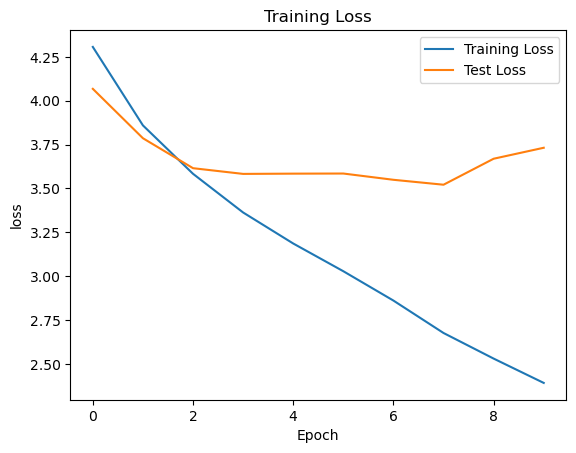

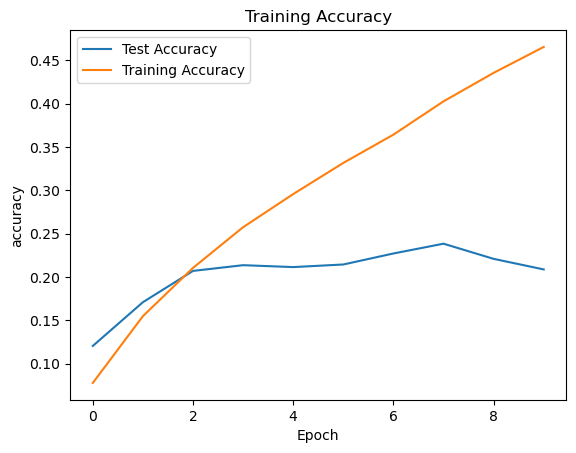

In [19]:
# Plotting training loss and accuracy
plt.plot(_log_train_loss, label='Training Loss')
plt.plot(_log_test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Training Loss')
plt.legend()
plt.show()


plt.plot(_log_test_acc, label='Test Accuracy')
plt.plot(_log_train_acc, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

In [21]:
torch.save(model.state_dict(), "Myresnet34.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [22]:
model = MyResNet34(Block, 100).to(device)
model.load_state_dict(torch.load("Myresnet34.pth"))

<All keys matched successfully>